STAT 489 Priciples of Data Science and Statistics
----
Author: Carson Hanel
Prof: Alan Dabney

NCI60 Data
----

Before diving into any analysis, first we must include the necessary libraries.

In [4]:
from collections import Counter, defaultdict
from functools import partial
import math, random, csv
import matplotlib.pyplot as plt
import dateutil.parser
import functools
import pandas as pd
import numpy as np

Let's read in the data for NCI60.
----

In [5]:
NCI        = pd.read_csv("datasets/NCI60.csv")  # Reading in the data
NCI_Labels = NCI["labs"]
type_count = list(Counter(NCI["labs"]).items()) # Derive type counts
NCI_60_data = NCI.values                 # Convert from DataFrame to NdArray
NCI_data    = NCI_60_data[:, 1:]
NCI = NCI.drop("labs", axis=1)

Check out the representation of Labels
----

In [6]:
# Cleanly print the class, count tuples.
for a, b in type_count:
    print(str(a) + " " + str(b))

MELANOMA 8
CNS 5
MCF7A-repro 1
UNKNOWN 1
OVARIAN 6
LEUKEMIA 6
COLON 7
BREAST 7
K562A-repro 1
NSCLC 9
MCF7D-repro 1
PROSTATE 2
K562B-repro 1
RENAL 9


Rescale the Data
----

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(NCI)
NCI    = scaler.transform(NCI)

Now, let's carry our Hierarchical Clustering
----

Import the preliminary necessary libraries.

In [8]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

Average Linkage
----

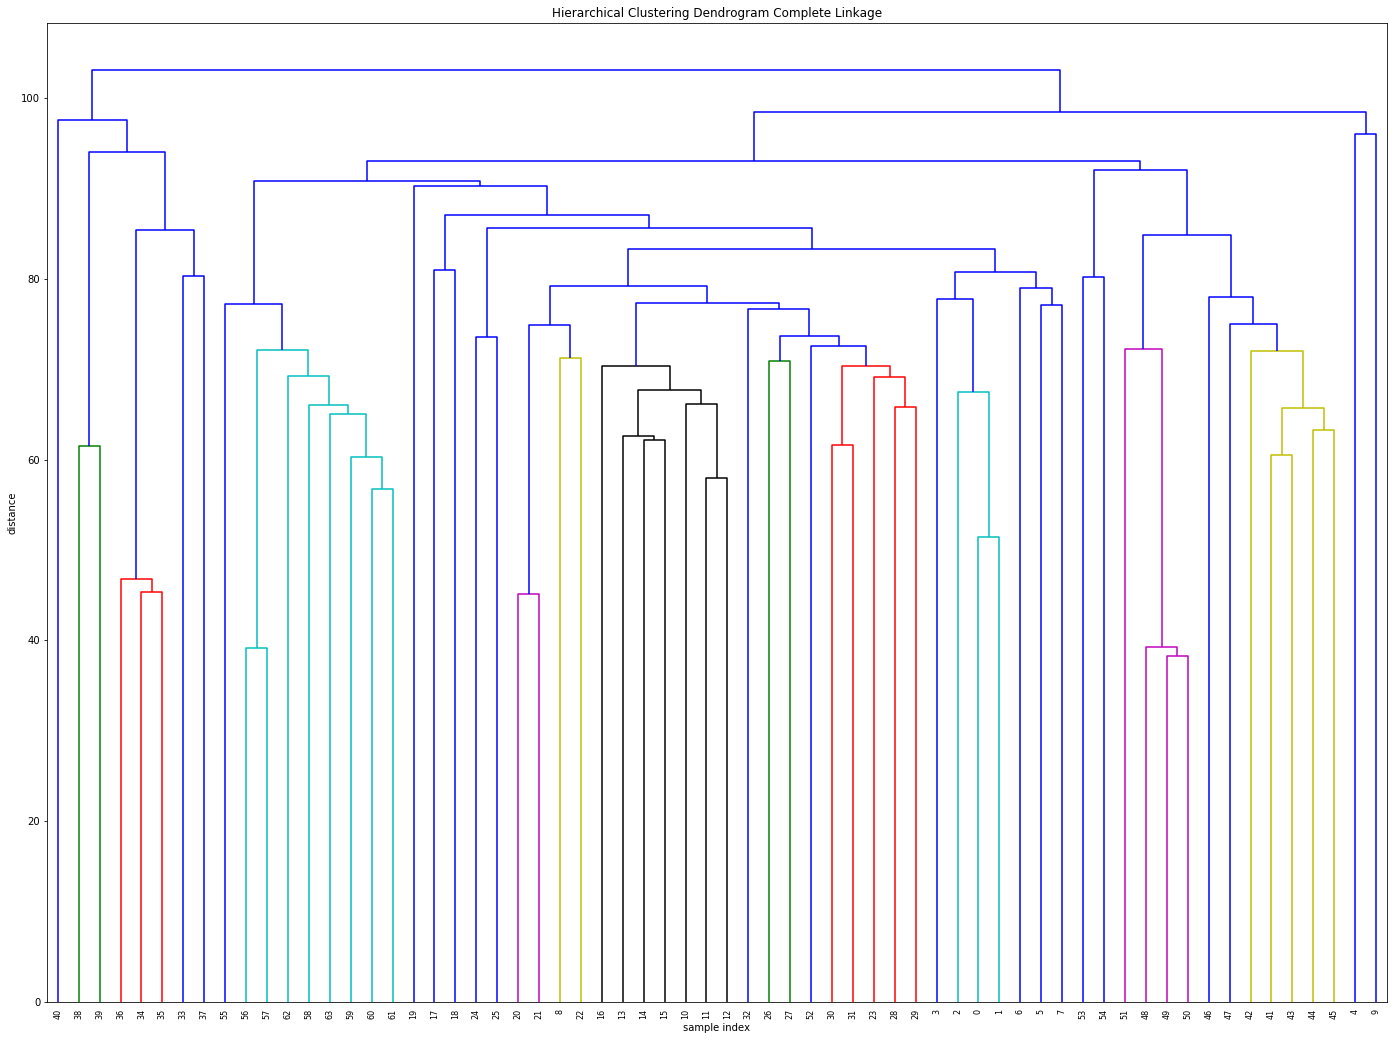

In [9]:
# Calculate the linkage
link = linkage(NCI_data, method = "average")

# Output the dendrogram
plt.figure(figsize = (24, 18))
plt.title("Hierarchical Clustering Dendrogram Complete Linkage")
plt.xlabel("sample index")
plt.ylabel("distance")
dendrogram(link, leaf_rotation = 90., leaf_font_size = 8)
plt.show()

Single Linkage
----

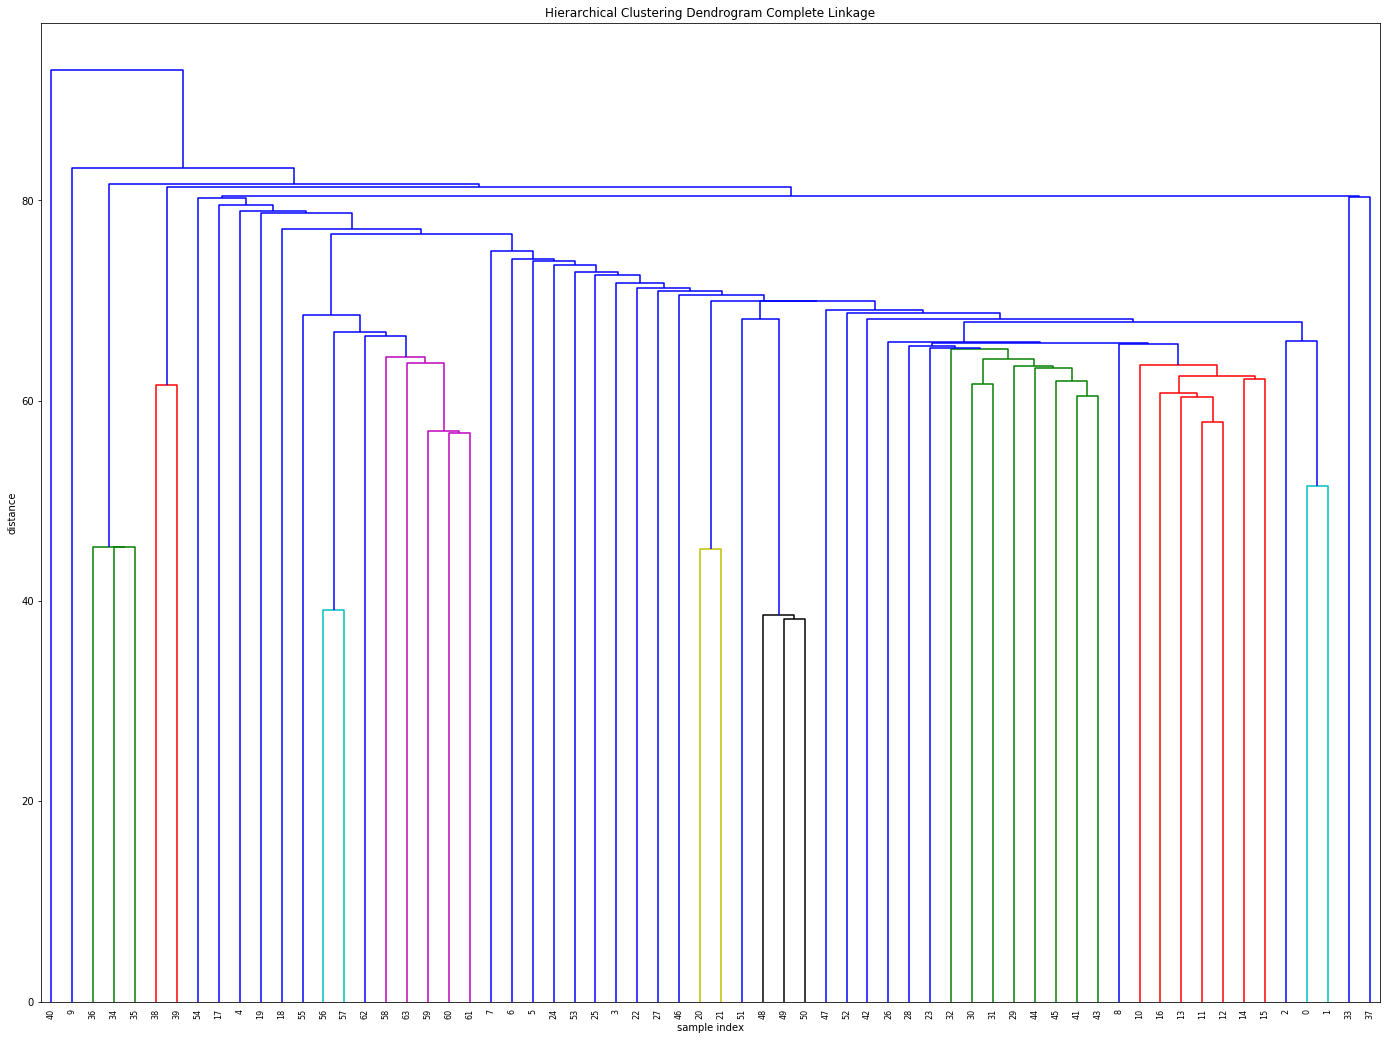

In [10]:
# Calculate the linkage
link = linkage(NCI_data, method = "single")

# Output the dendrogram
plt.figure(figsize = (24, 18))
plt.title("Hierarchical Clustering Dendrogram Complete Linkage")
plt.xlabel("sample index")
plt.ylabel("distance")
dendrogram(link, leaf_rotation = 90., leaf_font_size = 8)
plt.show()

Complete Linkage
----

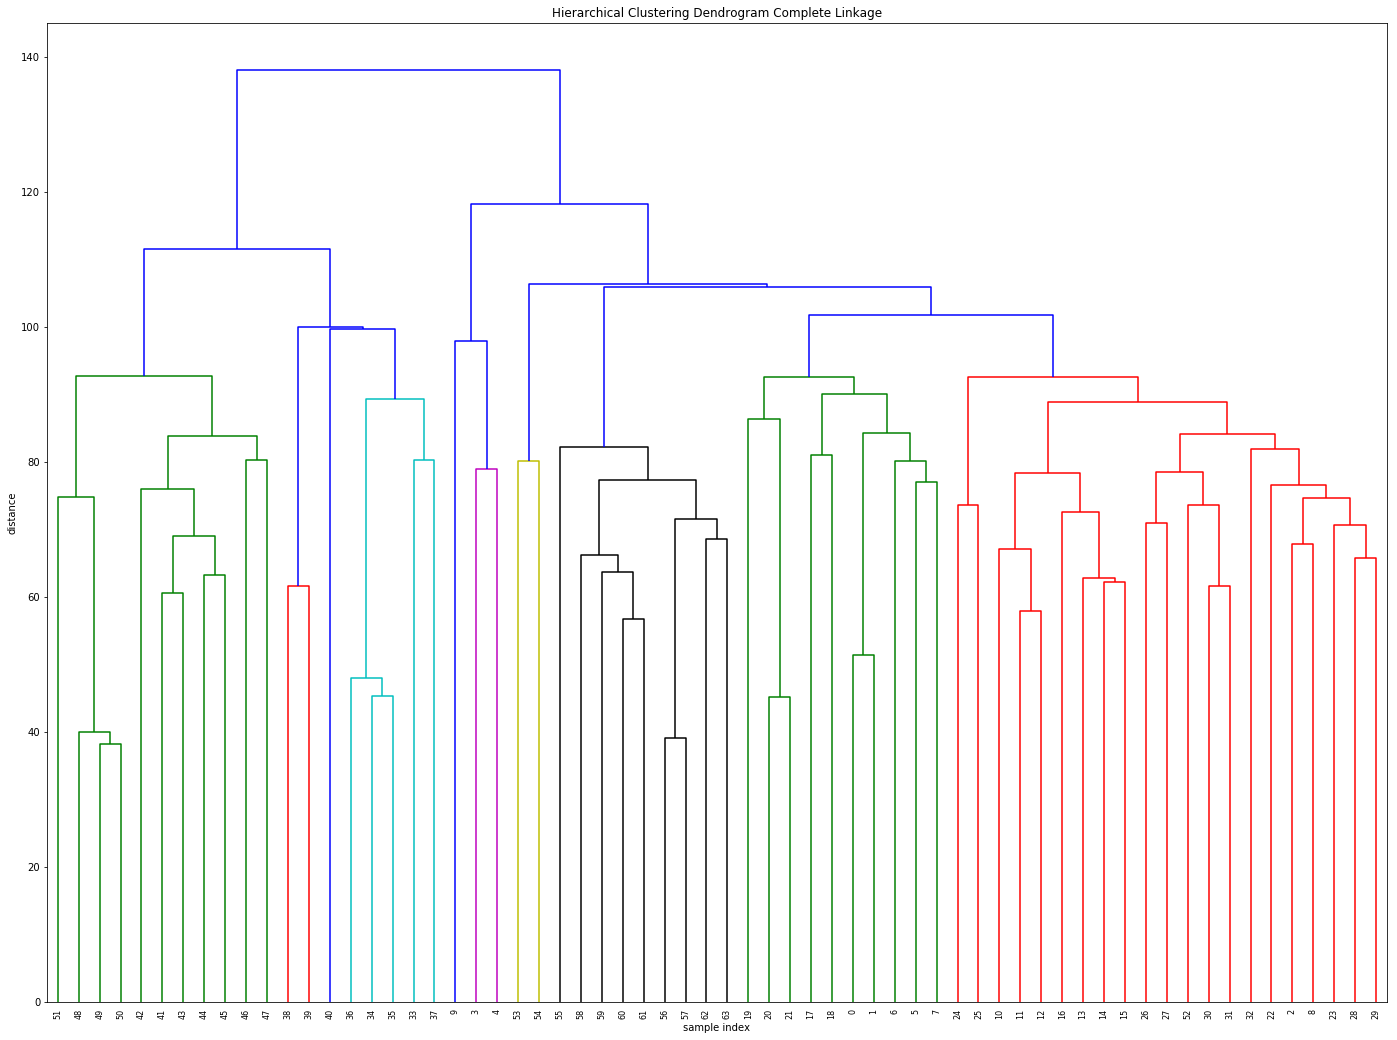

In [11]:
# Calculate the linkage
link = linkage(NCI_data, method = "complete")

# Output the dendrogram
plt.figure(figsize = (24, 18))
plt.title("Hierarchical Clustering Dendrogram Complete Linkage")
plt.xlabel("sample index")
plt.ylabel("distance")
complete = dendrogram(link, leaf_rotation = 90., leaf_font_size = 8)
plt.show()

Qualitative Differences in the Linkage method:
----
It seems that, going from $\textbf{single linkage}$ onward, single linkage is rather sparse in the hierarchical groupings; only data that's really similar is grouped as a homogeneous cluster, and more anomolous data is translated to a kind of analog blue grouping. It can be thought of as, the data clustered in blue are numerically dissimilar.

From there, $\textbf{Average linkage}$ has a much more defined structure of clustering, though, still those data that vary greatly from the "average" aren't picked up. It can be thought of as, the data clustered in blue are statistically unlikely to be grouped.

Finally, $\textbf{Complete Linkage}$ seems to really well take into account variances in variables and more accurately cluster by completely getting the most accurate clustering due to individually picking the greedy best groupings akin to Kruskal's algorithm, creating a minimum (optimal) spanning tree.

Distance between the two sub-clusters involved in the final merge event:
----

In [9]:
print("Distance between the final merge event: " + str(link[-1, 2]))

Distance between the final merge event: 138.150448756


Plot the Complete Linkage Scree Plot
----

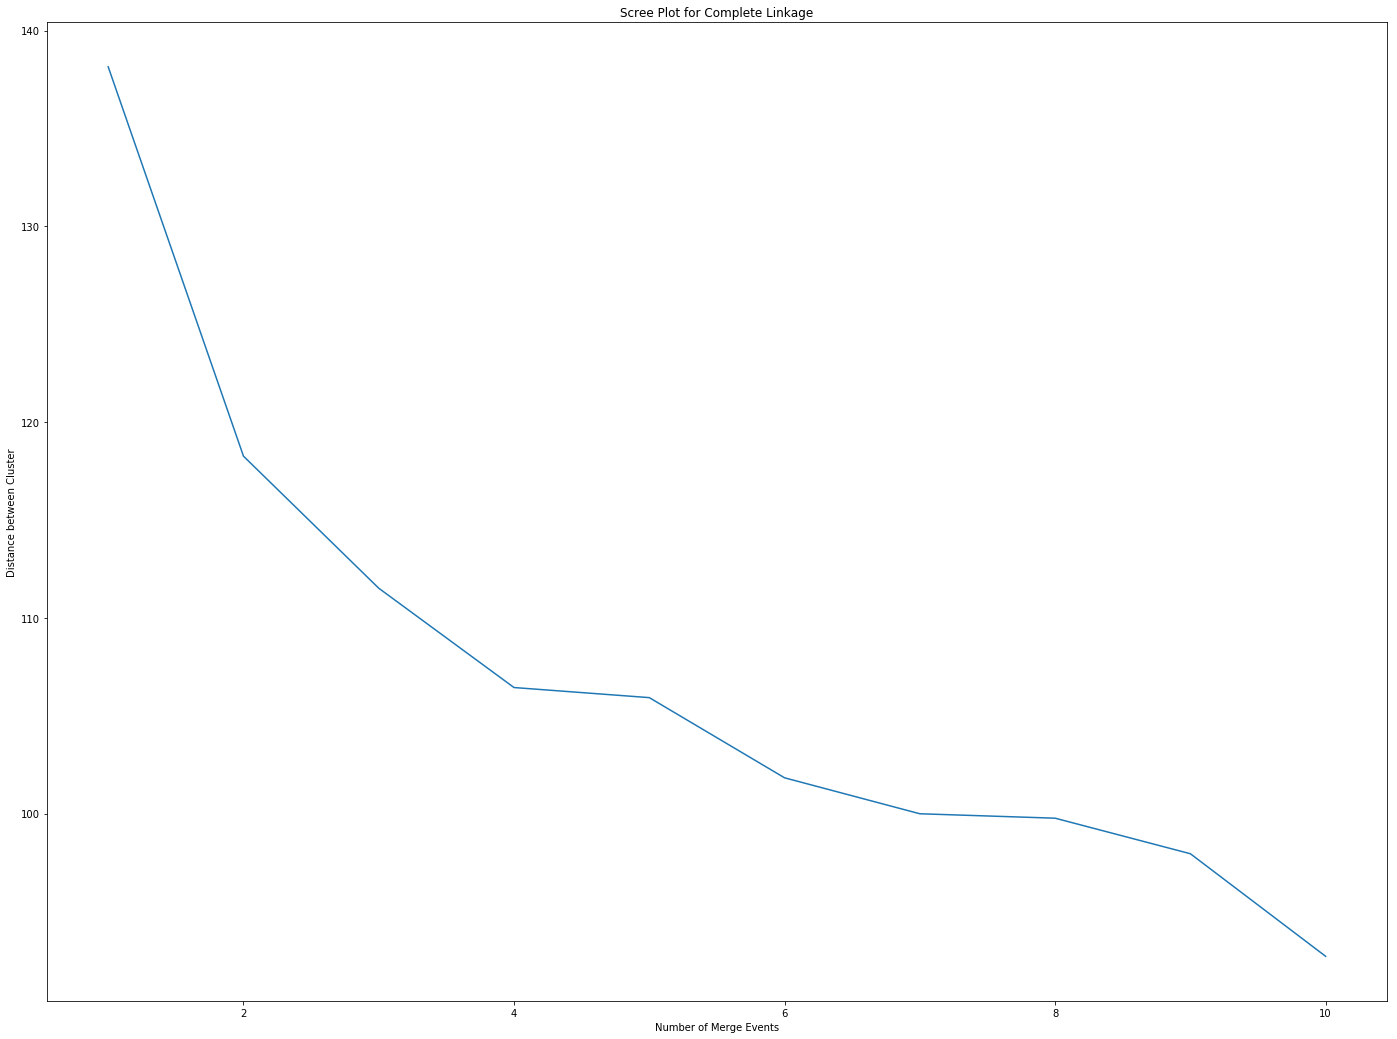

In [58]:
plt.figure(figsize = (24, 18))

last = link[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last_rev) + 1)
plt.title("Scree Plot for Complete Linkage")
plt.xlabel("Number of Merge Events")
plt.ylabel("Distance between Cluster")
plt.plot(idxs, last_rev)

Report the frequency table
----

In [28]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(linkage="complete",
                                n_clusters=10)
model = model.fit(NCI_data)

In [66]:
cluster_labels = complete["color_list"]
cluster_db = pd.DataFrame({'Cancer'     : NCI_Labels[:63],
                           'Cluster'   : model.labels_[:63]},
                       columns=['Cancer','Cluster'])
cluster_nd = cluster_db.values
cluster_db = cluster_db.groupby(["Cluster"])


# Print Clusters
#for key, item in cluster_db:
#    print cluster_db.get_group(key), "\n\n"
    
cancers       = set(NCI_Labels[:63])
clusters      = set(model.labels_[:63])
index_label   = []
cancer_matrix = []    
for cancer in cancers:
    index_label.append(cancer)
    temp = []
    for cluster in clusters:
          temp.append(len([x for x in cluster_nd if x[0] == cancer and x[1] == cluster]))
    cancer_matrix.append(temp)
    
freq_db = pd.DataFrame(data = cancer_matrix, columns = clusters, index= index_label)
print(freq_db)
    

             0  1  2  3  4  5  6  7  8  9
MELANOMA     0  1  0  0  0  6  0  0  0  0
CNS          0  1  4  0  0  0  0  0  0  0
MCF7A-repro  1  0  0  0  0  0  0  0  0  0
UNKNOWN      0  0  1  0  0  0  0  0  0  0
OVARIAN      0  5  1  0  0  0  0  0  0  0
LEUKEMIA     0  0  0  0  0  0  3  2  1  0
COLON        7  0  0  0  0  0  0  0  0  0
BREAST       2  0  2  1  0  2  0  0  0  0
K562A-repro  0  0  0  0  0  0  1  0  0  0
NSCLC        0  5  1  0  2  0  0  0  0  1
MCF7D-repro  1  0  0  0  0  0  0  0  0  0
PROSTATE     0  2  0  0  0  0  0  0  0  0
K562B-repro  0  0  0  0  0  0  1  0  0  0
RENAL        0  7  1  1  0  0  0  0  0  0


Takeaway:
----
From this, it would seem that there should be 7 clusters in K-means, though there are potentially 14 different types of cancer.

K-Means Clustering:
----

Fit the module to 10.

In [30]:
from sklearn.cluster import KMeans 

kmeans_10 = KMeans(n_clusters=10).fit(NCI_data) 

print("K-Means 10 Labels")
print(kmeans_10.labels_)

print("\nHierarchical Clustering labels:")
print(model.labels_)

K-Means 10 Labels
[0 0 0 0 4 4 7 7 7 4 4 4 4 4 4 4 4 7 4 7 7 7 5 5 5 5 5 5 5 5 5 5 5 5 3 3 3
 9 9 9 8 5 1 1 1 1 1 1 6 6 6 6 5 8 8 2 2 2 2 2 2 2 2 2]

Hierarchical Clustering labels:
[2 2 1 3 3 2 2 2 1 9 1 1 1 1 1 1 1 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 6 6 6 6
 6 7 7 8 0 0 0 0 0 0 0 0 0 0 0 1 4 4 5 5 5 5 5 5 5 5 5]


Report the Frequency Table
----

In [64]:
comparison_db = pd.DataFrame({'Cancer'      : NCI_Labels[:63],
                              'K-Means'     : kmeans_10.labels_[:63],
                              'Hierarchy'   : model.labels_[:63]},
                            columns=['Cancer','K-Means', "Hierarchy"])
comparison_nd = comparison_db.values
comparison_db = comparison_db.groupby(["Cancer"])

cancers       = set(NCI_Labels[:63])
clusters      = set(kmeans_10.labels_[:63])
index_label   = []
cancer_matrix = []    
for cancer in cancers:
    index_label.append(cancer)
    temp = []
    for cluster in clusters:
          temp.append(len([x for x in comparison_nd if x[0] == cancer and x[1] == cluster]))
    cancer_matrix.append(temp)
    
freq_db = pd.DataFrame(data = cancer_matrix, columns = clusters, index= index_label)
print(freq_db)

             0  1  2  3  4  5  6  7  8  9
MELANOMA     0  0  6  0  0  1  0  0  0  0
CNS          3  0  0  0  1  0  0  1  0  0
MCF7A-repro  0  0  0  0  0  0  1  0  0  0
UNKNOWN      0  0  0  0  0  0  0  1  0  0
OVARIAN      0  0  0  0  0  5  0  1  0  0
LEUKEMIA     0  0  0  1  0  1  0  0  1  3
COLON        0  6  0  0  0  1  0  0  0  0
BREAST       0  0  2  0  1  0  2  2  0  0
K562A-repro  0  0  0  1  0  0  0  0  0  0
NSCLC        0  0  0  0  2  4  0  1  2  0
MCF7D-repro  0  0  0  0  0  0  1  0  0  0
PROSTATE     0  0  0  0  0  2  0  0  0  0
K562B-repro  0  0  0  1  0  0  0  0  0  0
RENAL        1  0  0  0  7  0  0  1  0  0


Comparison:
----
Overall, the two clustering algorithms seem to be mostly in agreement, with $\textbf{Hierarchy}$ being the more well-defined clustering algorithm in this case.

Scatterplot of the first 2 Principle Components
----

0 is mapped to: BREAST Cancer.
1 is mapped to: CNS Cancer.
2 is mapped to: COLON Cancer.
3 is mapped to: K562A-repro Cancer.
4 is mapped to: K562B-repro Cancer.
5 is mapped to: LEUKEMIA Cancer.
6 is mapped to: MCF7A-repro Cancer.
7 is mapped to: MCF7D-repro Cancer.
8 is mapped to: MELANOMA Cancer.
9 is mapped to: NSCLC Cancer.
10 is mapped to: OVARIAN Cancer.
11 is mapped to: PROSTATE Cancer.
12 is mapped to: RENAL Cancer.
13 is mapped to: UNKNOWN Cancer.


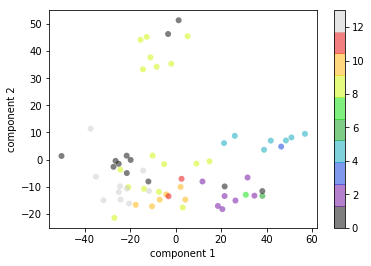

In [137]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

# Get Principle Components
pca = PCA(2)
projected = pca.fit_transform(NCI_data)

# Encode the Cancer Type
le = LabelEncoder()
le.fit(NCI_Labels)
le_name_mapping = list(zip(le.classes_, le.transform(le.classes_)))
le = le.fit_transform(NCI_Labels)

for x, y in le_name_mapping:
    print(str(y) + " is mapped to: " + str(x) + " Cancer.")

plt.scatter(projected[:, 0], projected[:, 1],
            c=le, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

Principle Component Analysis on Wine Data
----
Let's read in the dataset

In [36]:
wine_data = pd.read_csv("datasets/winequality_red.csv")  # Reading in the data
type_count = list(Counter(wine_data["quality"]).items()) # Derive type counts

wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Check out the representation of Quality:
----

In [37]:
# Cleanly print the class, count tuples.
for a, b in type_count:
    print(str(a) + " " + str(b))

3 10
4 53
5 681
6 638
7 199
8 18


Rescale the data
----

In [38]:
from sklearn.preprocessing import StandardScaler

wine_full = wine_data
wine_data = wine_data.drop("quality", axis=1)
scaler = StandardScaler().fit(wine_data)
wine_data = scaler.transform(wine_data)

Carry out Principle Component Analysis
----

In [39]:
from sklearn.decomposition import PCA

pca = []

for x in range(12):
    pca.append(PCA(n_components=x))
    pca[x].fit(wine_data)

See what proportion of Variance is explained by each Priciple Component
----

In [40]:
for x in range(len(pca[11].explained_variance_ratio_)):
    print("Principle Component [" + str(x + 1) + "] explains " 
          + str(pca[11].explained_variance_ratio_[x] * 100) 
          + " percent of the variance in the data.")

Principle Component [1] explains 28.1739312788 percent of the variance in the data.
Principle Component [2] explains 17.5082699055 percent of the variance in the data.
Principle Component [3] explains 14.095849898 percent of the variance in the data.
Principle Component [4] explains 11.0293866416 percent of the variance in the data.
Principle Component [5] explains 8.72083701224 percent of the variance in the data.
Principle Component [6] explains 5.99643877154 percent of the variance in the data.
Principle Component [7] explains 5.30719290175 percent of the variance in the data.
Principle Component [8] explains 3.84506090598 percent of the variance in the data.
Principle Component [9] explains 3.1331101529 percent of the variance in the data.
Principle Component [10] explains 1.64848333244 percent of the variance in the data.
Principle Component [11] explains 0.54143919929 percent of the variance in the data.


See how many Principle Components need to be included to explain 80% of the data:
----

From this, it would seem 5 would suffice if you're okay with 79.5. Otherwise, 6 components are necessary.

In [41]:
for item in range(len(pca)):
    print("Components [" + str(item) + "]: " + str(sum(pca[item].explained_variance_ratio_)))

Components [0]: 0
Components [1]: 0.281739312788
Components [2]: 0.456822011843
Components [3]: 0.597780510822
Components [4]: 0.708074377239
Components [5]: 0.795282747361
Components [6]: 0.855247135076
Components [7]: 0.908319064094
Components [8]: 0.946769673154
Components [9]: 0.978100774683
Components [10]: 0.994585608007
Components [11]: 1.0


Report a Scree Plot:
----

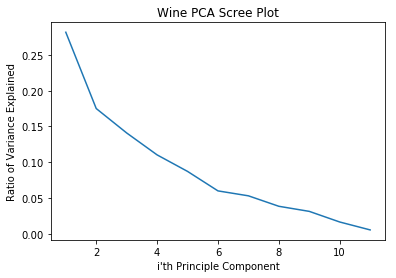

In [42]:
x = np.arange(1, 12, 1)
y = pca[11].explained_variance_ratio_

plt.title("Wine PCA Scree Plot")
plt.ylabel("Ratio of Variance Explained")
plt.xlabel("i'th Principle Component")
plt.plot(x, y)

Build a Correlation Matrix:
----

In [75]:
corr_mx = pd.DataFrame(wine_data).corr()
corr_mx

,0,1,2,3,4,5,6,7,8,9,10
0,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668
1,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288
2,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903
3,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075
4,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141
5,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408
6,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654
7,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180
8,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633
9,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595


Derive Eigan Values and Compare:
----

In [79]:
eig = np.linalg.eigvals(corr_mx)

tuples = []
for x in range(len(eig)):
    tuples.append((eig[x], pca[11].explained_variance_[x]))
    
for x in tuples:
    print("Eigan Value: " + str(x[0]) + " Explained Variance: " + str(x[1]) + " Discrepancy: " + str(abs(x[0]-x[1])))


Eigan Value: 3.09913244067 Explained Variance: 3.09913244067 Discrepancy: 1.24344978758e-14
Eigan Value: 1.9259096896 Explained Variance: 1.9259096896 Discrepancy: 6.66133814775e-16
Eigan Value: 1.55054348877 Explained Variance: 1.55054348877 Discrepancy: 2.6645352591e-15
Eigan Value: 1.21323253058 Explained Variance: 1.21323253058 Discrepancy: 2.88657986403e-15
Eigan Value: 0.959292071346 Explained Variance: 0.959292071346 Discrepancy: 6.66133814775e-16
Eigan Value: 0.0595583119219 Explained Variance: 0.659608264869 Discrepancy: 0.600049952948
Eigan Value: 0.181333166568 Explained Variance: 0.583791219193 Discrepancy: 0.402458052625
Eigan Value: 0.344642116819 Explained Variance: 0.422956699658 Discrepancy: 0.0783145828392
Eigan Value: 0.422956699658 Explained Variance: 0.344642116819 Discrepancy: 0.0783145828392
Eigan Value: 0.583791219193 Explained Variance: 0.181333166568 Discrepancy: 0.402458052625
Eigan Value: 0.659608264869 Explained Variance: 0.0595583119219 Discrepancy: 0.6000

Report the pairwise scatterplots of the first three PCA:
----

Components 1 and 2:
----

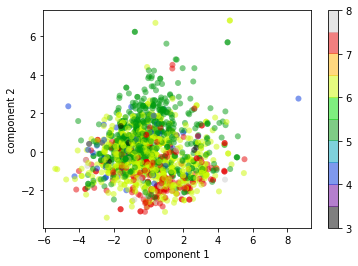

In [212]:
pca       = PCA(3)
projected = pca.fit_transform(wine_data) 

plt.scatter(projected[:, 0], projected[:, 1],
            c=wine_full["quality"], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

Components 3 and 2:
----

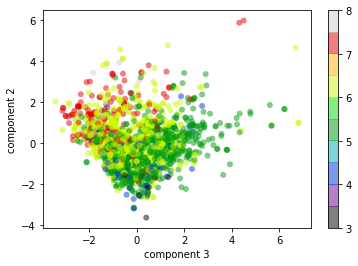

In [218]:
plt.scatter(projected[:, 1], projected[:, 2],
            c=wine_full["quality"], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.xlabel('component 3')
plt.ylabel('component 2')
plt.colorbar();

Components 1 and 2:
----

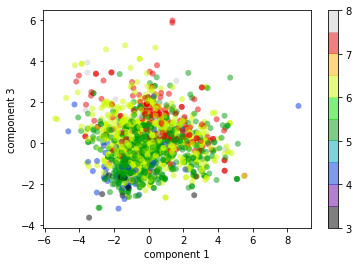

In [219]:
plt.scatter(projected[:, 0], projected[:, 2],
            c=wine_full["quality"], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 3')
plt.colorbar();

All Three Components:
----

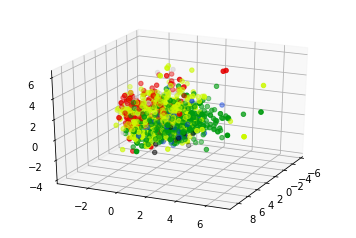

In [231]:
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(projected[:, 0], projected[:, 1], projected[:, 2], 
             c=wine_full["quality"], cmap=plt.cm.get_cmap('nipy_spectral', 10))

ax.view_init(25, 25)

Withdraw Eigan Vectors for PCA 1 coeffs
----

In [45]:
eig_vectors = np.linalg.eig(corr_mx)
print(eig_vectors[0])

[ 3.09913244  1.92590969  1.55054349  1.21323253  0.95929207  0.05955831
  0.18133317  0.34464212  0.4229567   0.58379122  0.65960826]


Intuition:
----

From looking at the coefficients, you can see fixed acidity, volatile acidity, citric acid, residual sugar are the top four variables that contribute to the score, with fixed acidity being the variable with the highest correlation with the intended target value.

Find the highest 5 absolute values on PC1:
----

In [50]:
raw_score  = wine_data * eig_vectors[0]
sum_       = np.array(np.abs(np.sum(raw_score,axis=1).tolist()))
x          = np.arange(0, len(sum_), 1).astype(int)

sum_tuples = np.column_stack((sum_, x))
sorted_t   = sorted(sum_tuples, key=lambda tup: tup[0])

highest    = sorted_t[-5:]
for x in highest:
    print("Principle Component 1 Score: " + str(x[0]) + " Location in DataFrame: " + str(int(x[1])) + "\n")
    print("Before PCA[0]:")
    print(wine_data[int(x[1])])
    print("")
    print("After PCA[0]:")
    print(wine_data[int(x[1])] * eig_vectors[0])
    print("")
    print("Quality :" + str(wine_full["quality"][int(x[1])]))
    print("-----------------------------------------------------------")
    print("")

Principle Component 1 Score: 18.8215504735 Location in DataFrame: 1434

Before PCA[0]:
[ 1.08032563  0.06804042  0.50849482  9.12473366  2.68930694  3.74156127
  1.47581431  3.68005512 -0.84951886  0.66006809 -1.3357151 ]

After PCA[0]:
[  3.34807222   0.1310397    0.78844333  11.07042371   2.57983083
   0.22284107   0.26761408   1.26830199  -0.35930969   0.38534196
  -0.88104872]

Quality :6
-----------------------------------------------------------

Principle Component 1 Score: 18.8215504735 Location in DataFrame: 1435

Before PCA[0]:
[ 1.08032563  0.06804042  0.50849482  9.12473366  2.68930694  3.74156127
  1.47581431  3.68005512 -0.84951886  0.66006809 -1.3357151 ]

After PCA[0]:
[  3.34807222   0.1310397    0.78844333  11.07042371   2.57983083
   0.22284107   0.26761408   1.26830199  -0.35930969   0.38534196
  -0.88104872]

Quality :6
-----------------------------------------------------------

Principle Component 1 Score: 20.4730311062 Location in DataFrame: 442

Before PCA[0]:
